### Clustering

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

In [45]:
with open('./data/cluster_data/stockcodes.json', 'r', encoding='utf-8') as f:
    codes = json.load(f)

df = pd.read_csv('./data/cluster_data/stockcandles_day.csv', dtype={'code':str})

In [46]:
def load_data():
    with open('./data/cluster_data/stockcodes.json', 'r', encoding='utf-8') as f:
        codes = json.load(f)

    df = pd.read_csv('./data/cluster_data/stockcandles_day.csv', dtype={'code':str})

    return codes, df

In [47]:
codes, df = load_data()

In [48]:
len(codes)

2375

In [49]:
df

,code,date,close,high,low,open,volume
0,082740,20220531,8730.0,8840.0,8520.0,8520.0,387301
1,082740,20220530,8510.0,8640.0,8380.0,8630.0,373313
2,082740,20220527,8450.0,8510.0,8240.0,8410.0,446609
3,082740,20220526,8390.0,8560.0,8220.0,8290.0,489793
4,082740,20220525,8260.0,8310.0,7990.0,8090.0,609532
...,...,...,...,...,...,...,...
322475,389030,20211115,12650.0,12950.0,12350.0,12600.0,272215
322476,389030,20211112,12650.0,13500.0,12250.0,12350.0,554986
322477,389030,20211111,12350.0,12900.0,12100.0,12100.0,450149
322478,389030,20211110,12150.0,12750.0,12100.0,12700.0,441404


In [50]:
df[df['code'] == '389030']

,code,date,close,high,low,open,volume
322341,389030,20220531,10900.0,11100.0,10800.0,10950.0,22787
322342,389030,20220530,11000.0,11150.0,10800.0,10950.0,43236
322343,389030,20220527,10850.0,11150.0,10750.0,10800.0,37268
322344,389030,20220526,10550.0,11000.0,10150.0,10150.0,104899
322345,389030,20220525,10150.0,10250.0,9950.0,10100.0,9856
...,...,...,...,...,...,...,...
322475,389030,20211115,12650.0,12950.0,12350.0,12600.0,272215
322476,389030,20211112,12650.0,13500.0,12250.0,12350.0,554986
322477,389030,20211111,12350.0,12900.0,12100.0,12100.0,450149
322478,389030,20211110,12150.0,12750.0,12100.0,12700.0,441404


In [51]:
X = []
names = []
w = 20
n = 120+w-1

for code_item in tqdm(codes):
    code = code_item['code']
    # print(f'code: {code}')
    _df = df[df['code'] == code].dropna()
    # print(f'len _df: {len(_df)}')

    if len(_df) < n:
        continue

    _df = _df.sort_values(by='date', ascending=True)
    _df['x'] = _df['close'] / _df.iloc[0]['close'] - 1
    _df = _df.dropna()
    # print(len(_df))

    if len(_df) < n:
        continue

    _df['x'] = pd.Series(_df['x']).rolling(w).mean()
    X.append(_df['x'].tolist()[w-1:])
    names.append(code_item['name'])

X = np.array(X)
names = np.array(names)

100%|██████████| 2375/2375 [01:05<00:00, 36.19it/s]


In [52]:
len(X)

2320

In [53]:
k = 30
model = KMeans(n_clusters=k, random_state=42)
model.fit(Normalizer().fit_transform(X))

from collections import Counter
print(Counter(model.labels_))

Counter({23: 309, 12: 194, 25: 193, 5: 134, 22: 124, 1: 114, 18: 112, 0: 100, 24: 81, 4: 79, 10: 77, 2: 72, 21: 69, 29: 67, 3: 60, 16: 54, 28: 54, 7: 50, 8: 44, 14: 42, 6: 41, 11: 40, 20: 37, 17: 35, 26: 30, 13: 29, 27: 21, 19: 21, 15: 19, 9: 18})


In [64]:
len(names)

2320

100
114
72
60
79
134
41
50
44
18
77
40
194
29
42
19
54
35
112
21
37
69
124
309
81
193
30
21
54
67


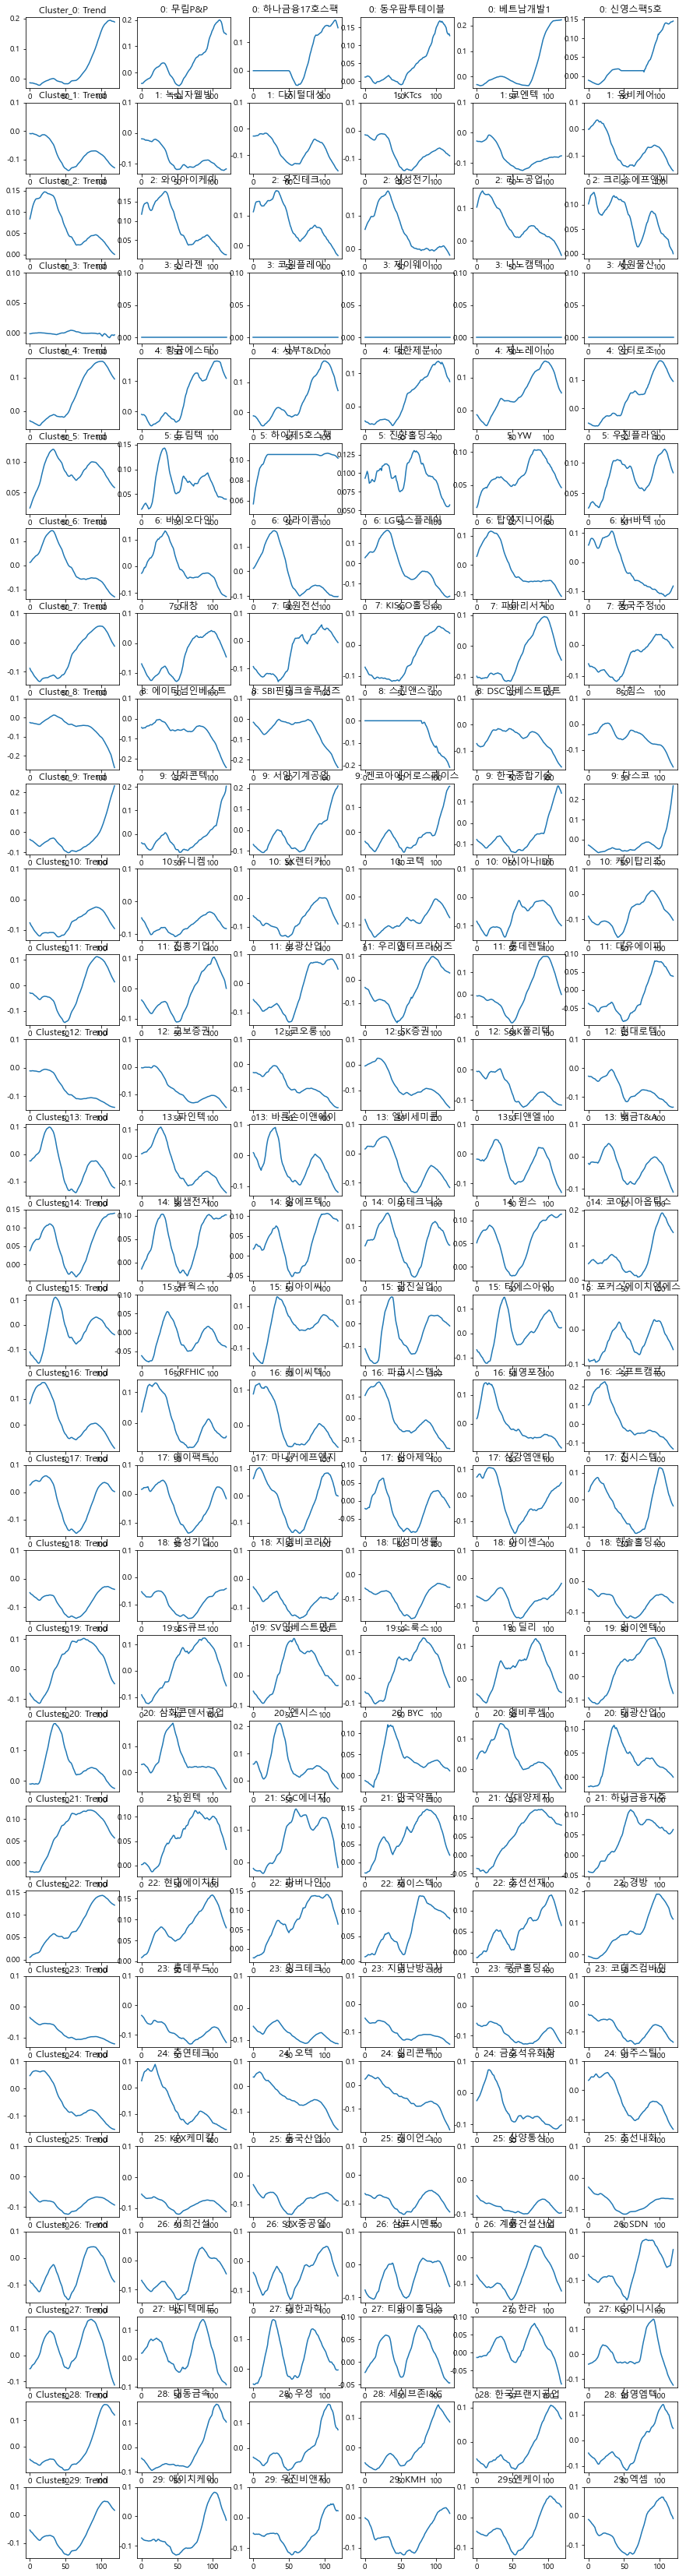

In [67]:
import matplotlib.font_manager as fm
import matplotlib
from scipy.spatial.distance import euclidean

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = 'Malgun Gothic'
fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rc('axes', unicode_minus=False)

def plot_clusters(model, k):
    %matplotlib inline
    c = 5
    fig, axes = plt.subplots(nrows=k, ncols=c+1, figsize=(c*3, k*2))

    for label in range(k):
        x = model.cluster_centers_[label]
        axes[label][0].plot(np.arange(len(x)), x)
        axes[label][0].set_title(f'Cluster_{label}: Trend')
        axes[label][0].set_ylim([min(x.min()-0.01, 0.1), max(x.max()+0.01, 0.1)])
        n = 0
        _X = X[model.labels_ == label]
        _names = names[model.labels_ == label]
        dist = [euclidean(x, _x) for _x in _X]
        idxs = np.argsort(dist)[:c]

        for x, name in zip(_X[idxs], _names[idxs]):
            n += 1
            axes[label][n].plot(np.arange(len(x)), x)
            axes[label][n].set_title(f'{label}: {name}')
            axes[label][n].set_ylim([min(x.min()-0.01, 0.1), max(x.max()+0.01, 0.1)])
            if n >= c:
                break

    plt.tight_layout()
    plt.show()

plot_clusters(model, k)

In [56]:
names[model.labels_ == 1]

array(['SK네트웍스', '대웅', '롯데하이마트', '미래에셋생명', '삼성출판사', '한국조선해양', 'SKC',
       '동양생명', '세방전지', '종근당', '한독', '한일현대시멘트', 'YG PLUS', '비비안', '유진증권',
       '유화증권', '종근당바이오', '텔코웨어', '한국자산신탁', '삼성물산', '세기상사', '셀트리온',
       '씨에스윈드', '평화홀딩스', '포스코스틸리온', '한화', 'DB금융투자', 'KPX홀딩스', '디아이동일',
       '부광약품', '신세계I&C', '카카오', '국도화학', '세아베스틸지주', '인바이오젠', '한올바이오파마',
       '효성첨단소재', '다우기술', '동화약품', '일양약품', '한국쉘석유', '한익스프레스', 'KTcs',
       '노루홀딩스', '대신증권', '동아에스티', '인스코비', '일성건설', '효성', '나스미디어', '디오',
       '알테오젠', '위지트', '휴메딕스', '옵티시스', '에이비프로바이오', '정상제이엘에스', '포스코케미칼',
       'SBS콘텐츠허브', '초록뱀컴퍼니', '디지털대성', '메디톡스', '쎌바이오텍', '아이오케이', '포스코 ICT',
       '한국경제TV', '신원종합개발', '지니뮤직', '초록뱀미디어', '코엔텍', '경동제약', '아즈텍WB',
       '앤디포스', '예스24', '이엠코리아', '파이오링크', '펩트론', '하이텍팜', '한국큐빅', '선익시스템',
       '위지윅스튜디오', 'iMBC', '대정화금', '동양이엔피', '디알젬', '에스트래픽', '이크레더블', '멜파스',
       '신일제약', '유비케어', '제룡산업', '차바이오텍', '코콤', '아이스크림에듀', '솔루스첨단소재',
       '씨에스베어링', '라파스', '녹십자웰빙', '에스케이바이오팜', '미투젠', '비비씨', '비나텍',
       '씨엔알리서치